**Welcome to the machine learning hackathon!**

We are developing a scoring model for secondary clients of the bank, which would predict the likelihood of a client's default. Fo this:
1. Analyze the data that is "on hand".
2. Conduct EDA and Feature Engeniring.
3. Determine the significant parameters of the borrower.
4. Run model, etc.

In [172]:
#pip install catboost --no-cache-dir

In [173]:
import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

Functions

In [174]:
#Create boxPlot with col list
def get_boxplot(column):
    #input - column list, output - boxPlot
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x='default', y=column, 
                data=data[data.Train == 1].loc[data[data.Train == 1].loc[:, column].isin(data[data.Train == 1].loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

#create category_plot. 
def get_catplot(column):
  #input colums list, output - catplot
  g = sns.catplot("default", col=column, col_wrap=7,
                data=data[data.Train == 1],
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')
  #fig.suptitle('sf')
  plt.show()

#create displot for int column
def get_displot(column):
  plt.figure()
  sns.distplot(data[data.Train == 1][column], kde = False, rug=False)
  plt.title(i)
  plt.show()

#just to calculate is customer income median, low or hight by region
def is_median_income(median, income):
  x = median/100*80
  y = median/100*120
  if x <= income <= y:
    return('median')
  elif x > income:
    return('low')
  else:
    return('hight')

#show_roc_curve just for easiest next work
def show_roc_curve(model, X_test, y_test):
  probs = model.predict_proba(X_test)
  probs = probs[:,1]


  fpr, tpr, threshold = roc_curve(y_test, probs)
  roc_auc = roc_auc_score(y_test, probs)

  plt.figure()
  plt.plot([0, 1], label='Baseline', linestyle='--')
  plt.plot(fpr, tpr, label = 'Regression')
  plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc = 'lower right')
  plt.show()


#delete one list from another
def set_approach(a,b):
    return list(set(a)-set(b))

In [175]:
#Read data and see examples
data_directory = '../input/sfdst-credit-scoring/'
df_train = pd.read_csv(data_directory+'train.csv', sep=',')
df_test = pd.read_csv(data_directory+'test.csv', sep=',')
sample_submission = pd.read_csv(data_directory+'/sample_submission.csv')

df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


*   client_id - client identification
*   app_date  - request date
*   education - education level
*   sex - sex
*   age - age
*   car - have car?
*   car_type - foreign machine
*   decline_app_cnt - number of rejected past requests
*   good_work - is client work is good work?
*   score_bki - some score from BKI (Credit History Bureau)
*   bki_request_cnt - requests to BKI
*   region_rating - internal rating of the region 
*   home_address - home address categorizer
*   work_address - work address categorizer
*   income - salary etc
*   sna - communication client with the bank's clients
*   first_time - the age of availability of information about the borrower
*   foreign_passport - Have a passport for traveling abroad?
*   default - credit default chance

In [176]:
#colums by type for easies work with them
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time']
time_cols = ['app_date']

In [177]:
df_train.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,55137.965094,39.280641,0.275749,0.164894,-1.904724,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,31841.921168,11.520378,0.804272,0.371087,0.498231,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,27440.500000,30.000000,0.000000,0.000000,-2.259534,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,55274.000000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,82758.500000,48.000000,0.000000,0.000000,-1.569831,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,110147.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [178]:
df_train['Train'] = 1 # train data
df_test['Train'] = 0 # test data

data = pd.concat([df_train, df_test], ignore_index=True) #concat and work with all data

In [179]:
#what about NAN?
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

NANs only in education and in the sign of default (test sample, as I understand it). There are not many NAN, you do not need to build a graph for visualization. Let's go straight to the EDA. 

# EDA

Let's start with education NAN. What values are there?

<AxesSubplot:>

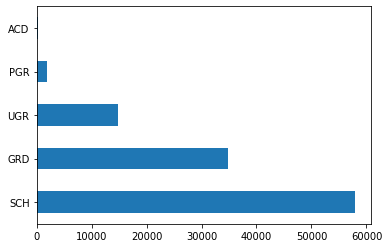

In [180]:
data['education'].value_counts().plot.barh()

Let's fill in the NAN with the most popular education in a group with the same gender, car, region, good job and a foreign passport.

In [181]:
data['education'] = data.groupby(['sex','car','region_rating','good_work','foreign_passport'], sort=False)['education'].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [182]:
#here I fill in the nan in Default with a negative value, so that later it is easy to understand what is what
data.default.fillna((-1), inplace=True)

### See category cols

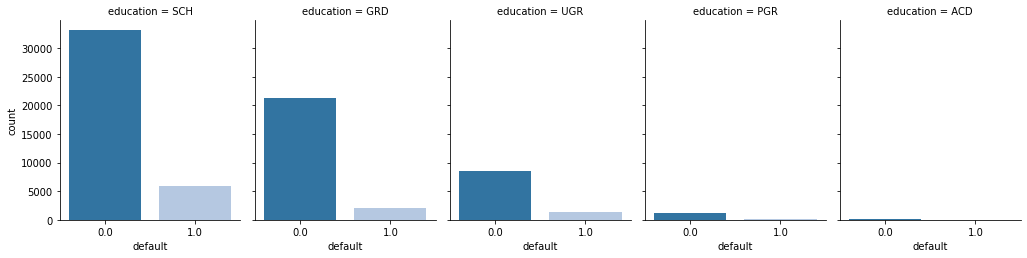

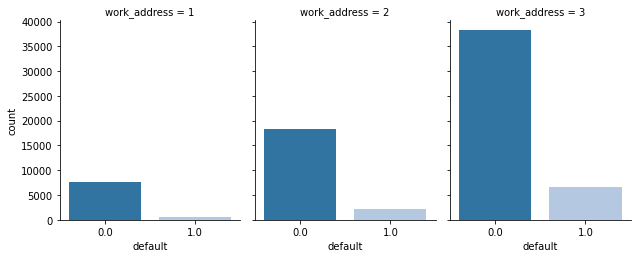

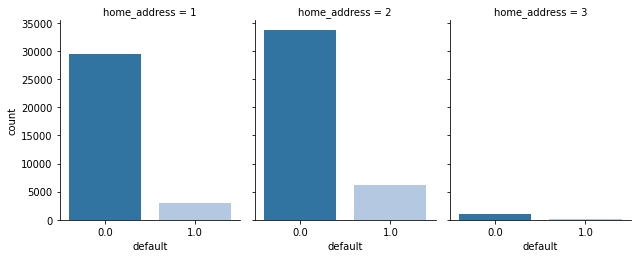

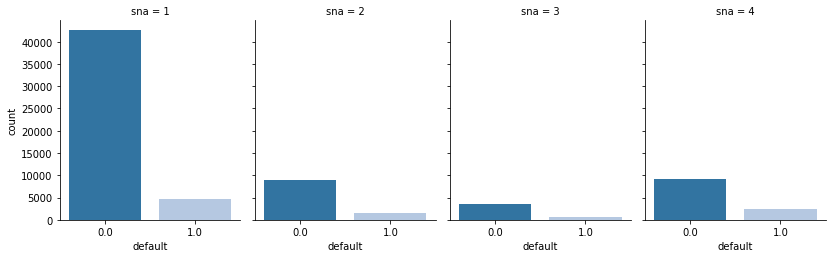

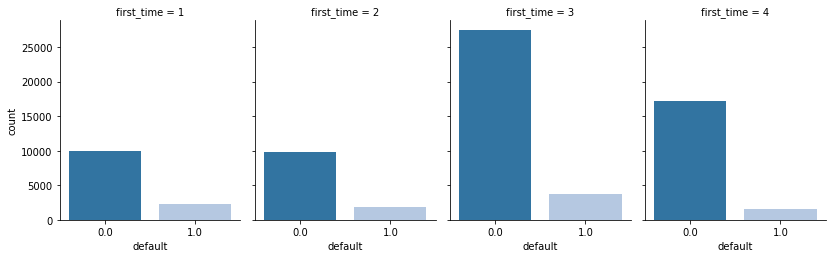

In [183]:
for col in cat_cols:
  get_catplot(col)

SNA = 4, home_address = 2 and first_time = 1 - according to the charts, most likely they will not return the loan.

There are very few people with ACD and PGR education, or they rarely take loans. 

### See numeric cols

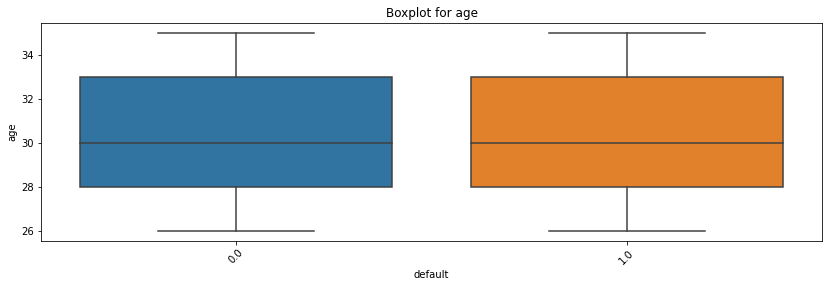

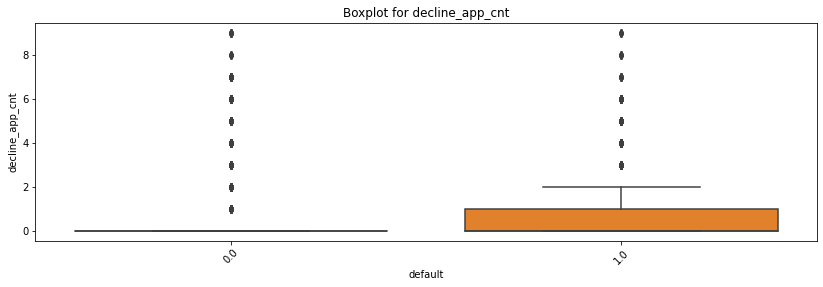

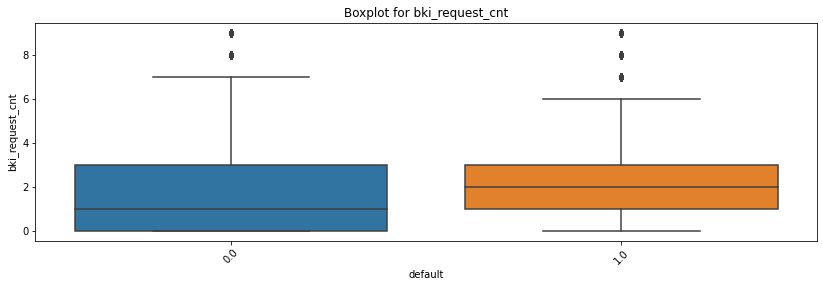

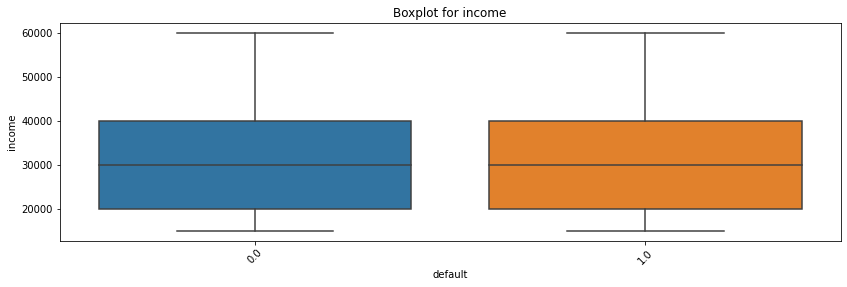

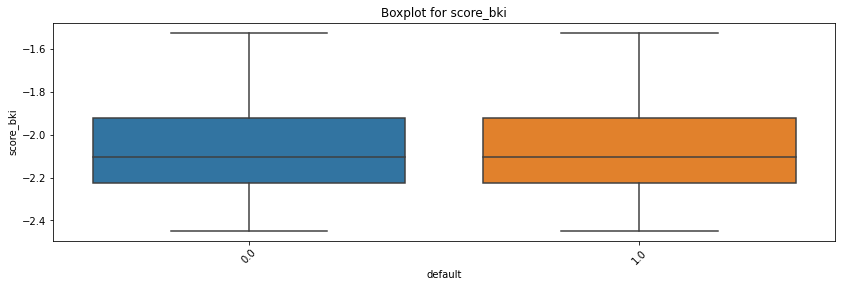

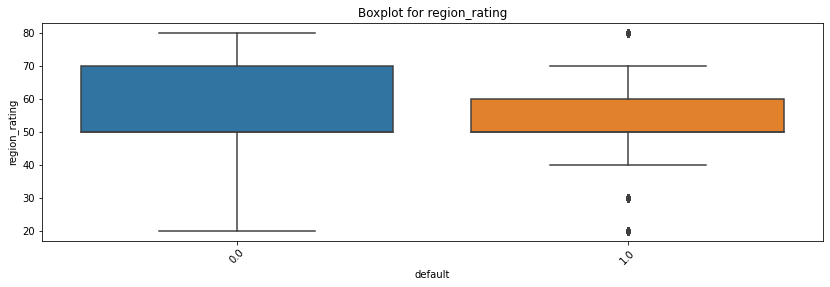

In [184]:
for col in num_cols:
  get_boxplot(col)

Conclusions:
* If you were previously denied loans (decline_app_cnt), then there is a chance of no return.
* 2+ inquiries to the credit bureau is a bad call.
* Non-payers - mostly - "middle band" (50-60). The emissions where the rating is 20-30 and default = 1 look interesting. those who did not repay the loan there are rather an exception to the rule.

But: the age, salary and score of the BKI do not affect the chance of loan repayment.


### Well, let's check that the distribution of numeric cols

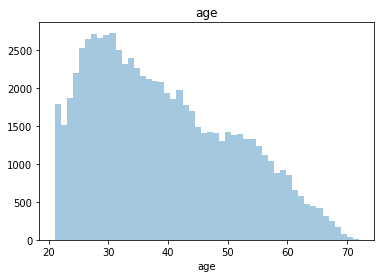

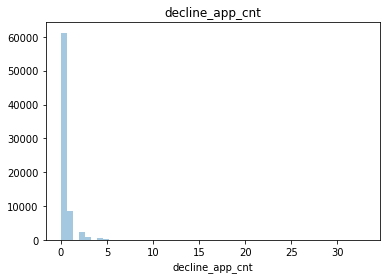

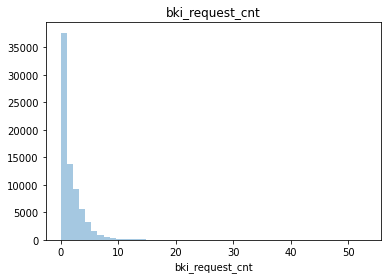

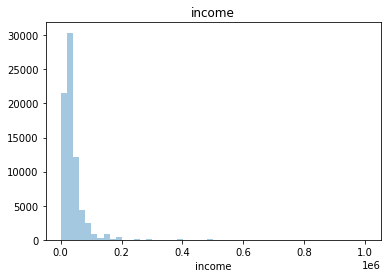

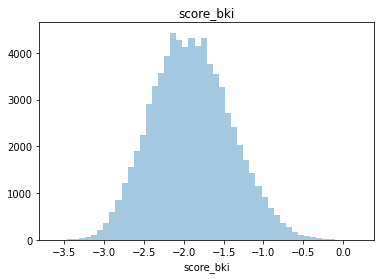

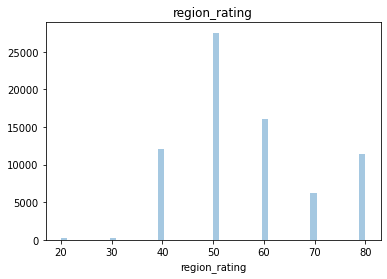

In [185]:
for i in num_cols:
  get_displot(i)

There are not so many people with a lot of loan refusals.

And the distribution of people by region is explained by one of the previous graphs.

Skore_BKI will need to be converted to a positive value to make it easier to logarithm.

### Data

In [186]:
#transform app_date to normal date
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

In [187]:
#a clean date won't tell us much. Let's try to create a variable - number of days from the date to today.
data['date_diff_today'] = pd.datetime.today() - data.app_date
data['date_diff_today'] = data['date_diff_today'].dt.days
data.drop(['app_date'], axis=1, inplace=True)

# Data transformation and Feature Engineering

In [188]:
#binary_cols to binary value
label_encoder = LabelEncoder()

for col in bin_cols:
  data[col] = label_encoder.fit_transform(data[col])

In [189]:
#education to 0-4 values
education_dict = {'SCH': 0,
                  'GRD': 1,
                  'UGR': 2,
                  'PGR': 3,
                  'ACD': 4 }


data['education'] = data['education'].map(education_dict)

In [190]:
#new col median_income - median_income by region_rating
median_income = data.groupby(['region_rating'], sort=True)['income'].agg(['median'])
median_income = median_income.rename(columns={'median': 'median_income'}) 

data = median_income.merge(data, on='region_rating', how='inner') #соединяем с нашим

In [191]:
#difference between median income by region and customer income
data['income_vs_median'] = data['income']-data['median_income']

In [192]:
#is customer income is median by region? categorize value
data['is_median_income'] = np.vectorize(is_median_income)(data['median_income'], data['income'])

In [193]:
#dummy-cols by type on income
data = pd.get_dummies(data, columns=['is_median_income'])

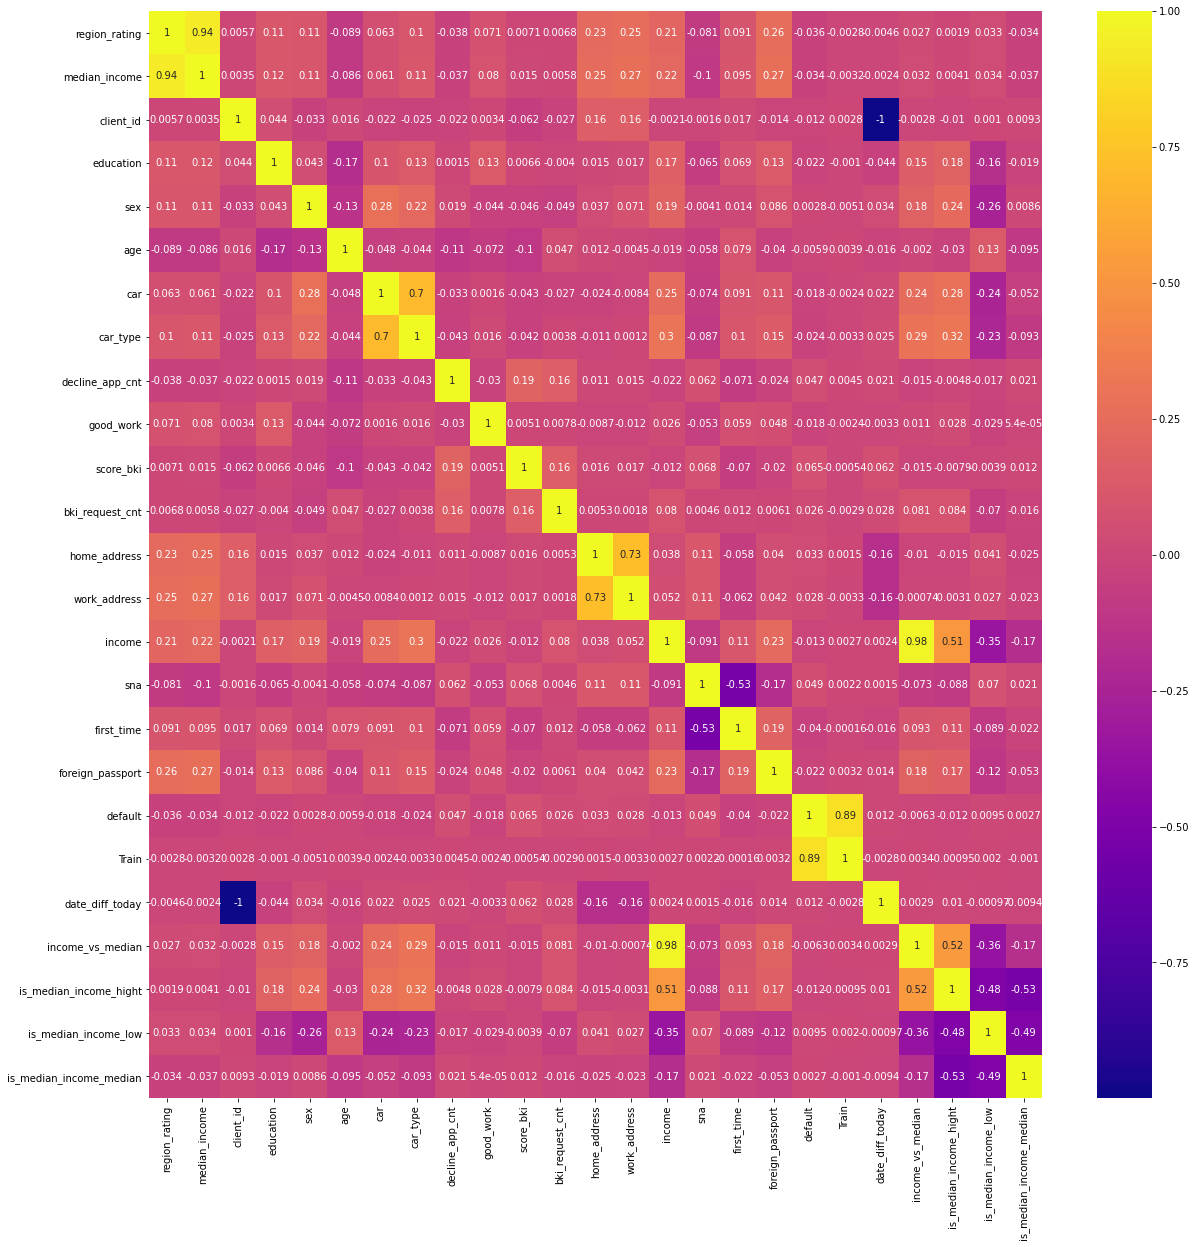

In [194]:
#let see our correlations
fig, ax = plt.subplots(1,1, figsize = (20,20))
ax = sns.heatmap(data.corr(),annot = True, cmap = 'plasma')

Can see how the Income affects the car, cat_type, foreign_passport, and so on.

Median income close to region rating,home address close to work address(make one col?)

In [195]:
#new feature - bki_cnt_first_time
data['bki_cnt_first_time'] = data['bki_request_cnt'] * data['first_time']

In [196]:
#new feature - home&work_address
data['hw_address'] = data['home_address']+data['work_address']

<AxesSubplot:>

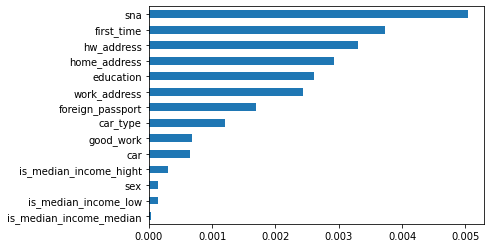

In [197]:
#add new field to list bin_cols and show dependency between default and bin_cols + cat_cols
new_cols = ['is_median_income_hight','is_median_income_low','is_median_income_median', 'hw_address']
bin_cols.extend(new_cols)

dependency = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
dependency.sort_values(inplace = True)
dependency.plot(kind = 'barh')

<AxesSubplot:>

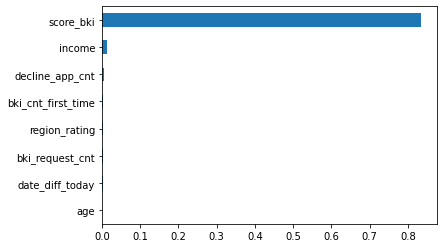

In [198]:
#add new field to list num_cols and show dependency between default and num_cols
new_cols = ['date_diff_today','bki_cnt_first_time']
num_cols.extend(new_cols)

dependency = pd.Series(mutual_info_classif(data[num_cols], data['default'],
                                     discrete_features =True), index = num_cols)
dependency.sort_values(inplace = True)
dependency.plot(kind = 'barh')

In [199]:
data.head()

,region_rating,median_income,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,...,foreign_passport,default,Train,date_diff_today,income_vs_median,is_median_income_hight,is_median_income_low,is_median_income_median,bki_cnt_first_time,hw_address
0,20,23679,98030,1,0,28,0,0,0,1,...,0,0.0,1,2639,-8679,0,1,0,8,5
1,20,23679,66242,0,0,42,1,0,0,0,...,0,0.0,1,2670,1321,0,0,1,18,5
2,20,23679,66347,0,1,35,1,0,0,0,...,0,0.0,1,2670,16321,1,0,0,0,5
3,20,23679,45142,1,1,36,1,1,0,1,...,0,1.0,1,2692,-3679,0,0,1,0,5
4,20,23679,106127,0,1,39,0,0,0,0,...,0,1.0,1,2629,-3679,0,0,1,3,5


In [200]:
#drop extra colums
data.drop(columns = ['income_vs_median','median_income', 'client_id',
                     'is_median_income_median', 'home_address',
                     'work_address'], inplace=True)
data.drop(columns = ['region_rating', 'date_diff_today', 'age'], inplace=True)

#and from num_cols list
del_cols = [ 'region_rating', 'date_diff_today', 'age','bki_request_cnt']
num_cols = set_approach(num_cols, del_cols)

Outliers?

In [201]:
for col in num_cols:
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    print("Columns: ", col)
    print("Underline: {u}, Upperline: {p}".format(u=len(data[col].loc[(data[col] < (perc25 - 1.5*IQR) )]), p=len(data[col].loc[(data[col] > (perc75 + 1.5*IQR) )])))

Columns:  score_bki
Underline: 82, Upperline: 436
Columns:  income
Underline: 0, Upperline: 7000
Columns:  bki_cnt_first_time
Underline: 0, Upperline: 3599
Columns:  decline_app_cnt
Underline: 0, Upperline: 18677


There are Outliers, but in this situation we believe that they can be

# Scale numeric cols

In [202]:
#scale 
scaler = MinMaxScaler()
data[num_cols] = scaler.fit_transform(data[num_cols].values)

The first results on the platform were extremely low. The assumption is that due to the small number of default clients

In [203]:
#can see difference
df_train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

In [204]:
train = data[data.Train == 1].drop(['Train'], axis=1)
test = data[data.Train == 0]

In [205]:
cli = train[train['default']==0]
default_cli = train[train['default']==1]

default_new = int(len(cli)/len(default_cli))
for i in range(default_new):
    df_train = df_train.append(ones).reset_index(drop=True)

In [206]:
df_train.default.value_counts()

1.0    65604
0.0    64427
Name: default, dtype: int64

Should be better

# Aaaand Start

split data

In [207]:
test = test.drop(['Train','default'], axis=1)

X = train.drop('default', axis=1).values
y = train['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

№1 LogisticRegression

0.8608546892731923


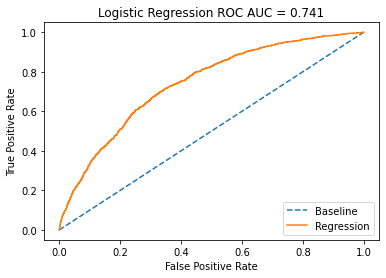

In [208]:
#best ROC AUC 0.741
clf = LogisticRegression(C=1, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                    random_state=None, solver= 'liblinear', tol=0.0001, verbose=0,
                    warm_start=False).fit(X_train, y_train)
print(clf.score(X_train, y_train))
show_roc_curve(clf, X_test, y_test)

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

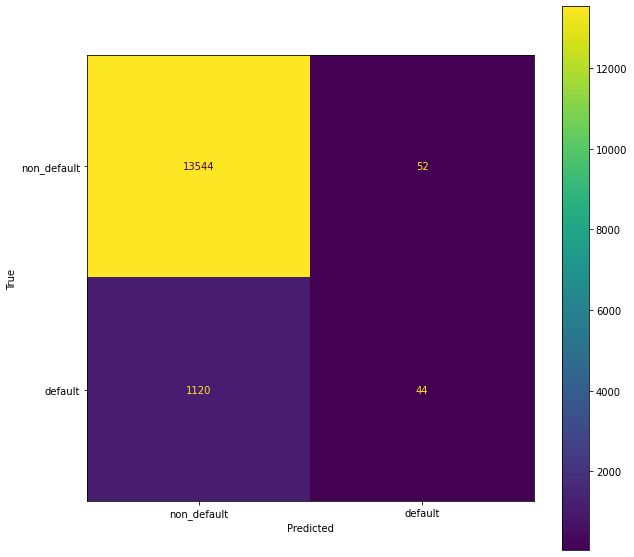

In [209]:
y_pred = clf.predict(X_test)


predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['non_default','default'])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax,  values_format = '')
disp.ax_.set(xlabel='Predicted', ylabel='True')

№2 CatBoost

0.8617015870865021


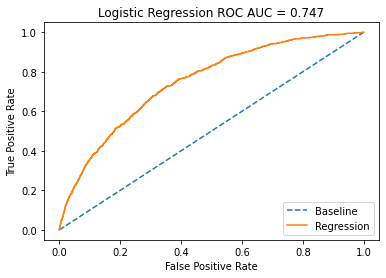

In [210]:
#best ROC AUC 0.747
catbst = CatBoostClassifier(iterations=100,
                           metric_period=100,
                            depth=5,
                           learning_rate=0.07).fit(X_train, y_train, verbose=False, eval_set=(X_train, y_train))

print(catbst.score(X_train, y_train))
show_roc_curve(catbst, X_test, y_test)


№3 LGBMClassifier

[LightGBM] [Warning] Unknown parameter: iterations
0.861261200223581


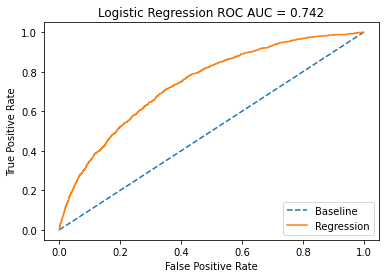

In [211]:
#ROC AUC 0.742
lgbm = LGBMClassifier(iterations=100, learning_rate = 0.3, boosting_type= 'gbdt'
                      , colsample_bytree= 0.65, max_bin= 255, n_estimators= 16
                      , num_leaves= 6, objective= 'binary', random_state= 500
                      , reg_alpha= 1.2, reg_lambda= 1.2, subsample=0.7).fit(X_train, y_train)

print(lgbm.score(X_train, y_train))
show_roc_curve(lgbm, X_test, y_test)

№4 XGBClassifier

[09:01:20] WARNING: ../src/learner.cc:541: 
Parameters: { iterations } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:01:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.861430579786243


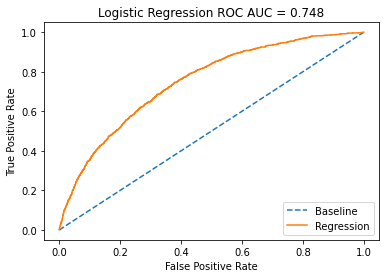

In [212]:
#best ROC AUC 0.748
xgb = XGBClassifier(iterations=100, colsample_bytree= 0.01, gamma= 8,
                    learning_rate= 0.4, max_depth= 3, min_child_weight= 10, 
                    subsample= 0.6).fit(X_train, y_train)
print(xgb.score(X_train, y_train))
show_roc_curve(xgb, X_test, y_test)

<img src="https://miro.medium.com/max/390/1*KTr6fY-beuzwICSDJeofww.jpeg" />


Seems like XGBClassifier is better choice(but just a little bit better)

### predict, create CSV etc

In [213]:
test = data[data.Train == 0].drop(['Train','default'], axis=1)
y_pred = xgb.predict_proba(test)

results_df = pd.DataFrame(data={'client_id':df_test['client_id'], 'default':y_pred[:,1]})

In [214]:
results_df.head()

,client_id,default
0,74835,0.102008
1,17527,0.147793
2,75683,0.249828
3,26883,0.131955
4,28862,0.135576


In [215]:
results_df.to_csv('submission.csv', index=False)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640
5,175,0.311599
6,57558,0.584807
7,88407,0.815792
8,79183,0.325037
9,69300,0.094011
